# Introduction:

UrbanSound8K - Classification:
dataset contains 8732 labeled sound excerpts
10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music.
All excerpts are taken from field recordings uploaded to www.freesound.org.


Our Goals:
1. 

### Importing:

In [ ]:
! pip install keras

In [ ]:
! python3 -m pip install tensorflow

In [ ]:
! pip3 install tqdm

In [ ]:
! pip3 install google

In [1]:
# importing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import keras
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax, Conv2D, MaxPool2D, Dropout, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import datasets, layers, models


pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns

import pickle

import tensorflow as tf

import os
# import librosa
# import librosa.display
import glob 

import csv
from scipy import signal
from scipy.io import wavfile

import time

from scipy.fft import fft, fftfreq

from numpy import save
from tqdm import tqdm

import pickle


# from google.colab import drive
# import skimage


/Users/tuval/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# drive.mount('/gdrive')

# EDA:

## Pip install:

In [ ]:
! pip install matplotlib

In [ ]:
! pip install seaborn

## Import:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


## Data extraction

In [ ]:
df = pd.read_csv('df.csv')

## Data understanding

In [ ]:
df.head()

In [ ]:
df = df.drop(['Unnamed: 0', 'slice_file_name', 'fsID', 'salience', 'fold'], axis=1)

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
for col in df.columns:
    print(col, len(df[col].unique()), df[col].unique())

In [ ]:
df.describe()

In [ ]:
df.dtypes

## Data preparation

In [ ]:
df["time_duration"] = df["end"] - df["start"]
df

## Data visualizations

In [ ]:
plt.figure(figsize= (20, 6))
sns.violinplot(x= 'class', y= 'start', data= df).set_title('Start time')
plt.show()

In [ ]:
df.corr()


In [ ]:
df.duplicated().sum()

In [ ]:
plt.figure(figsize= (20, 6))

sns.stripplot(x ='class', y ='time_duration', data = df,
              jitter = True, dodge = True)
plt.show()

# Feature engineering:

- 3.1 Functions def:

In [ ]:
# path - tuval env:
directory_path = 'data/' 

In [ ]:
 

def get_spectrogram_data(path, fft_size=2048,overlap_ratio=0, restrict_freq=(0,11025)):
    samplerate, audiodata  = wavfile.read(path) # 44100
    data = audiodata.astype(float)
    
    #if "mono" the data is duplicated else the data is "streo"
    if len(data.shape) > 1:
        data = audiodata.sum(axis=1) / 2

    N = len(data)  
    time = N / samplerate # 176400/44100 =time sec
    freq = N/time # should get 22.05kHz

    samplerate_fixed = 22050 # 22050*4 = 88200
    data = signal.resample(data, int(samplerate_fixed*time))  
    time = N/samplerate_fixed
    freq = N/time 
    samplerate = samplerate_fixed

    # resize data. all files should get the same length of time
    if len(data) < 88200: # 176400
        data = np.append(data,np.zeros(88200-len(data)))
    else:
        data = data[:88200]

    # resample thr data to 22.05 kHZ. 
    # input parameter: samples. therfore fixed_sample_rate * audio time
    f_raw, time, Sxx_raw = signal.spectrogram(data, fs=samplerate, nperseg=fft_size, window="hann", noverlap=overlap_ratio*fft_size)

    freq = f_raw[(f_raw>=restrict_freq[0]) & (f_raw<=restrict_freq[1])]
    Sxx= Sxx_raw[(f_raw>=restrict_freq[0]) & (f_raw<=restrict_freq[1]),:]
    
    total = np.sum(Sxx)
    Sxx= Sxx/total
    Sxx_log = 10*np.log10(Sxx + 0.00001)
    Sxx_log = Sxx_log - Sxx_log.min()
    return Sxx_log, time, freq


def signal_plotting(path):
    samplerate, audiodata  = wavfile.read(path) # 44100
    data = audiodata.astype(float)
    
    #if "mono" the data is duplicated else the data is "streo"
    if len(data.shape) > 1:
        data = audiodata.sum(axis=1) / 2
    data = data
    N= len(data)
    yf = fft(data)
    xf = fftfreq(N, samplerate)[:N//2]
    plt.subplot(2,1,1) 
    plt.plot(data)
    plt.ylabel('amplitude')
    plt.xlabel('Time')
    plt.title('audio signal')
    plt.subplot(2,1,2) 
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.xlabel('frequncy')
    plt.title('audio signal')
    plt.tight_layout()
    plt.grid()
    plt.show()

    
def spec_plotting(path, fft_size=2048,overlap_ratio=0.25):    
    Sxx_log, time, freq = get_spectrogram_data(path ,fft_size=fft_size,overlap_ratio=overlap_ratio)
    plt.subplot(2,1,1) 
    plt.pcolormesh(time, freq,Sxx_log, shading='gouraud')
    plt.ylabel('Frequency')
    plt.xlabel('Time [sec]')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram')
    plt.subplot(2,1,2) 
    plt.pcolormesh(time, np.log10(freq+1), Sxx_log, shading='gouraud')
    plt.ylabel('10*log10(f)')
    plt.xlabel('Time [sec]')
    plt.colorbar(format='%+2.0f dB')
    plt.title('logarithmic -frequency power spectrogram')
    plt.tight_layout()
    plt.show() 


def get_df_spec_data(df, fft_size=2048,overlap_ratio=0.25):
    results = []
    for i, path in enumerate(df):
        if i% 50==0:
            print (round(i/df.shape[0]*100,0),"%" )
            
        Sxx_log, time, freq = get_spectrogram_data(path ,fft_size=fft_size,overlap_ratio=overlap_ratio)
        results.append(Sxx_log)
    return results

    

def repeat_and_reshape(X_train, X_test,dup_size):
    input_size = X_train.shape[1]

    X_train_len = X_train.shape[0]
    X_test_len =X_test.shape[0]

    X_train = np.repeat(X_train, dup_size, axis=1)
    X_train = X_train.reshape(X_train_len, input_size, dup_size, 1)


    X_test = np.repeat(X_test, dup_size, axis=1)
    X_test = X_test.reshape(X_test_len, input_size, dup_size, 1)


    return (X_train, X_test)

- 3.2 Extract data:

In [ ]:
# directory_path = '/gdrive/My Drive/Data Science/Final_project/sound_data/'
file_name='UrbanSound8K.csv'
def get_paths_lables_df(directory_path,file_name):
    path = directory_path + file_name
    df = pd.read_csv(path)
    df['relative_path'] =  directory_path+ '/fold'+  df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)
    df = df[['relative_path', 'classID','class']]
    print('count: ', df.shape[0])
   
    return df

In [ ]:
def get_df_spec_data(df, fft_size=4000,overlap_ratio=0.1):
    spec_data = []
    y_labels =[]
    
    for index, row in tqdm(df.iterrows()):
        path= row['relative_path']
        if os.path.exists(path):    
            Sxx_log, time, freq = get_spectrogram_data(path ,fft_size=fft_size,overlap_ratio=overlap_ratio)
            spec_data.append(Sxx_log)
            y_labels.append(row['classID'])
    ## creat numpy arrays of the 2 lists spec_data, y_labels
    spec_data=np.array(spec_data)
    y_labels=np.array(y_labels)
    return spec_data,y_labels

In [ ]:
# # efrat:

# start_time = time.time()

# # Construct feature by concatenating fold and file name
# df = get_paths_lables_df(directory_path,file_name)

# # rows num to filter- drop out the rows of files with wrong file format
# df = df.drop(index=[4803,6246,6247,6248,6249,6250,6251,6252,6253,8337,8338],axis=0)
# rows =len(df)

# spec_data,y_labels = get_df_spec_data(df, fft_size=2048,overlap_ratio=0.2)



In [ ]:
# print(f"Spec data shape: {spec_data.shape}.\ny label shape: {y_labels.shape}")



In [ ]:
# # We save x into the current directory as 
# np.save(directory_path +'spec_data_np', spec_data)
# np.save(directory_path +'y_labels_np', y_labels)

# Split to Train / Test and Validation

In [27]:

import glob


directory_path = 'data/'
# create list with all .npz files
npz_files = []
for file in glob.glob(directory_path + '*.npz'):
    npz_files.append(file)


# Load data
npz_file = npz_files[3]

data=np.load(npz_file, allow_pickle=True)
x_data=data['X']
y_data=data['y']
y_data = to_categorical(y_data)

In [28]:
npz_file

'data/8732_128_2048_0.25.npz'

In [29]:
x_data, X_Validation, y_data, Y_Validation = train_test_split(x_data, y_data, test_size=0.1 ,random_state = 123)
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.3 ,random_state = 123)

print('X_Validation.shape: ' + str(X_Validation.shape))
print('X_train.shape: ' + str(X_train.shape))
print('X_test.shape: '+ str(X_test.shape))


X_Validation.shape: (874, 128, 57)
X_train.shape: (5500, 128, 57)
X_test.shape: (2358, 128, 57)


In [30]:
X_Validation = X_Validation.reshape(X_Validation.shape[0],X_Validation.shape[1],X_Validation.shape[2],1)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

input_dim = (X_train.shape[1],X_train.shape[2],1)

In [31]:
## Clear RAM for the run
del(x_data)


# Models

Choose the number of categories for the model to classify
if original file- 10 
if file with birds- 13

In [32]:
num_categories=10

## Efrat model:

In [ ]:

    model_EF_2 = Sequential()
    model_EF_2.add(Conv2D(64, (5, 5), padding = "same", activation = "tanh", input_shape = input_dim))
    model_EF_2.add(MaxPool2D(pool_size=(2, 2)))
    model_EF_2.add(Conv2D(64, (5, 5), padding = "same", activation = "tanh", input_shape = input_dim))
    model_EF_2.add(MaxPool2D(pool_size=(2, 2)))    
    model_EF_2.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
    model_EF_2.add(MaxPool2D(pool_size=(2, 2)))    
    model_EF_2.add(Conv2D(32, (3, 3), padding = "same", activation = "tanh"))
    model_EF_2.add(MaxPool2D(pool_size=(2, 2)))
    model_EF_2.add(Dropout(0.1))
    model_EF_2.add(Flatten())
    model_EF_2.add(Dense(1024, activation = "tanh"))
    model_EF_2.add(Dense(num_categories, activation = "softmax"))

    model_EF_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:

    model_EF_3 = Sequential()
    model_EF_3.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
    model_EF_3.add(MaxPool2D(pool_size=(2, 2)))
    model_EF_3.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
    model_EF_3.add(MaxPool2D(pool_size=(2, 2)))
    model_EF_3.add(Dropout(0.1))
    model_EF_3.add(Flatten())
    model_EF_3.add(Dense(1024, activation = "tanh"))
    model_EF_3.add(Dense(num_categories, activation = "softmax"))

    model_EF_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [33]:
model_EF_4 = Sequential()
model_EF_4.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape = input_dim))
model_EF_4.add(MaxPool2D(pool_size=(2, 2),  strides=(2, 2)))
model_EF_4.add(Conv2D(64, (5, 5), activation='relu'))
model_EF_4.add(MaxPool2D(pool_size=(2, 2)))
model_EF_4.add(Dropout(0.1))
model_EF_4.add(Flatten())
model_EF_4.add(Dense(1000, activation = "relu"))
model_EF_4.add(Dense(num_categories, activation = "softmax"))

model_EF_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Imri model:

In [ ]:
model_IM_1 = models.Sequential()
model_IM_1.add(layers.Conv2D(filters=32,kernel_size=(3, 3),padding='same', activation='relu'))
model_IM_1.add(layers.MaxPooling2D((2, 2)))
model_IM_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_IM_1.add(layers.MaxPooling2D((2, 2)))
model_IM_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_IM_1.add(Dropout(0.2))

model_IM_1.add(layers.Flatten())
model_IM_1.add(Dense(128, activation='relu'))
model_IM_1.add(Dropout(0.5))
model_IM_1.add(Dense(num_categories,activation = "softmax"))

model_IM_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
model_IM_2 = Sequential()

model_IM_2.add(Conv2D(filters=32,kernel_size=(3, 3),padding='same',activation='relu'),)
model_IM_2.add(MaxPooling2D(pool_size=(2, 2)))
model_IM_2.add(Dropout(0.25))

model_IM_2.add(Conv2D(filters=64,kernel_size=(3, 3), padding = "same", activation = "tanh"))
model_IM_2.add(MaxPooling2D(pool_size=(2, 2)))
model_IM_2.add(Dropout(0.25))
model_IM_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_IM_2.add(MaxPooling2D(pool_size=(2, 2)))
model_IM_2.add(Dropout(0.25))

model_IM_2.add(Flatten())
model_IM_2.add(Dense(256, activation='relu'))#my addition
model_IM_2.add(Dropout(0.5))
model_IM_2.add(Dense(128, activation='relu'))
model_IM_2.add(Dense(num_categories, activation='softmax'))

model_IM_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
model_IM_3 = Sequential()
model_IM_3.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh"))
model_IM_3.add(MaxPool2D(pool_size=(2, 2)))
model_IM_3.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model_IM_3.add(MaxPool2D(pool_size=(2, 2)))
model_IM_3.add(Dropout(0.1))
model_IM_3.add(Flatten())
model_IM_3.add(Dense(1024, activation = "tanh"))
model_IM_3.add(Dense(num_categories, activation = "softmax"))

model_IM_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Fit model:

In [34]:

# Fit model by model name: [EF_2, EF_3, EF_4, IM_1, IM_2, IM3]

model_name= 'EF_4' + '_' + npz_file.split('/')[1].split('.npz')[0]

model=model_EF_4

csv_logger = tf.keras.callbacks.CSVLogger('results/log/' +  model_name +  '.csv', separator=str(u','), append= False)   


################################
history = model.fit(
    X_train, 
    Y_train, 
    epochs = 40, 
    batch_size = 30,
    validation_data = (X_test, Y_test), 
    callbacks = [csv_logger]) # Save log into CSV



model_path='results/files/' +  model_name
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# with open(model_path, 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)




Epoch 1/40
184/184 [==============================] - 102s 554ms/step - loss: 1.2063 - accuracy: 0.5951 - val_loss: 0.8153 - val_accuracy: 0.7193
Epoch 2/40
184/184 [==============================] - 117s 633ms/step - loss: 0.5718 - accuracy: 0.8142 - val_loss: 0.5280 - val_accuracy: 0.8367
Epoch 3/40
184/184 [==============================] - 92s 500ms/step - loss: 0.3076 - accuracy: 0.8993 - val_loss: 0.5546 - val_accuracy: 0.8533
Epoch 4/40
184/184 [==============================] - 84s 458ms/step - loss: 0.1785 - accuracy: 0.9413 - val_loss: 0.5103 - val_accuracy: 0.8787
Epoch 5/40
184/184 [==============================] - 89s 485ms/step - loss: 0.1004 - accuracy: 0.9693 - val_loss: 0.5694 - val_accuracy: 0.8762
Epoch 6/40
184/184 [==============================] - 86s 469ms/step - loss: 0.0792 - accuracy: 0.9764 - val_loss: 0.6486 - val_accuracy: 0.8639
Epoch 7/40
184/184 [==============================] - 82s 445ms/step - loss: 0.0384 - accuracy: 0.9889 - val_loss: 0.6718 - val_

INFO:tensorflow:Assets written to: ram://07b5f0fb-74e6-48ff-a83f-fd8e2ba2f2fe/assets


INFO:tensorflow:Assets written to: ram://07b5f0fb-74e6-48ff-a83f-fd8e2ba2f2fe/assets


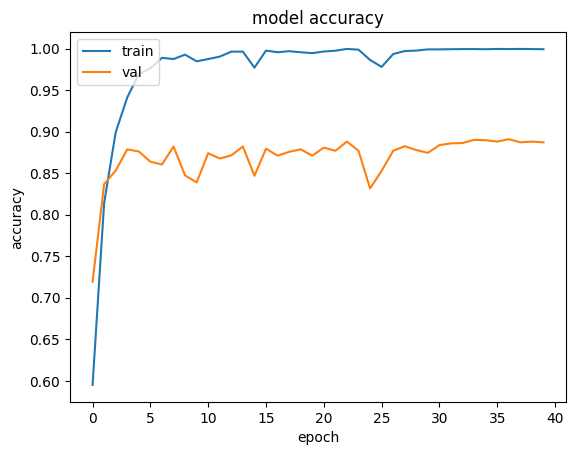

In [35]:
# only for plot

def plot_model_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()



plot_model_history(history)

In [ ]:
# Training

# 1. Load model
model_name= 'IM_2' + '_' + npz_file.split('/')[1].split('.npz')[0]
model_path='results/files/' +  model_name


# # Load model as pickle
with open(model_path, 'rb') as handle:
    model_IM_2 = pickle.load(handle)
model_IM_2

# Load model as pickle history
# history = pickle.load(open(model_path, "rb"))
# # 2. Train model

model=model_IM_2

# model = history


csv_logger = tf.keras.callbacks.CSVLogger('results/log/' +  model_name +  '.csv', separator=str(u','), append= False)   


history = model.fit(
    X_train, 
    Y_train, 
    epochs = 2, 
    batch_size = 30,
    validation_data = (X_test, Y_test), 
    callbacks = [csv_logger]) # Save log into CSV


# # 3. Save results
# # with open(model_path, 'wb') as f:
# #     pickle.dump(model, f)

with open(model_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


In [ ]:
print(history.params)


In [ ]:
model_path

In [ ]:
# Imri fit
# Choose which model to run
model=model_EF_2

model.fit(X_train, Y_train, epochs = 90, batch_size = 30, validation_data = (X_test, Y_test))

# Evaluation

In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score

## Summary Results:

In [ ]:

log_path = 'results/log/'

# create list with all CSV files
all_files = []
for file in glob.glob(log_path + '*.csv'):
    all_files.append(file)



In [ ]:
all_files

['results/log/EF_3_8732_064_2048_0.25.csv',
 'results/log/IM_2_8732_256_2048_0.25.csv',
 'results/log/EF_4_8732_064_2048_0.25.csv',
 'results/log/EF_2_8732_256_2048_0.25.csv',
 'results/log/IM_3_8732_064_2048_0.25.csv',
 'results/log/IM_1_8732_256_2048_0.25.csv',
 'results/log/EF_4_8732_256_2048_0.25.csv',
 'results/log/IM_2_8732_064_2048_0.25.csv',
 'results/log/EF_3_8732_256_2048_0.25.csv',
 'results/log/IM_1_8732_064_2048_0.25.csv',
 'results/log/IM_3_8732_256_2048_0.25.csv',
 'results/log/EF_2_8732_064_2048_0.25.csv',
 'results/log/EF_4_8732_128_2048_0.25.csv',
 'results/log/EF_3_8732_128_2048_0.25.csv',
 'results/log/IM_2_8732_016_2048_0.25.csv',
 'results/log/IM_3_8732_032_2048_0.25.csv',
 'results/log/EF_4_8732_032_2048_0.25.csv',
 'results/log/IM_1_8732_016_2048_0.25.csv',
 'results/log/EF_3_8732_032_2048_0.25.csv',
 'results/log/EF_2_8732_016_2048_0.25.csv',
 'results/log/IM_3_8732_128_2048_0.25.csv',
 'results/log/IM_2_8732_128_2048_0.25.csv',
 'results/log/EF_3_8732_016_2048

In [ ]:
# Add new column with file name

for i in all_files:
    
    df=pd.read_csv(i)
    df['File name'] = i.split(".csv")[0]

    df.to_csv(i.split(".csv")[0]+".csv", index=False)


df

,epoch,accuracy,loss,val_accuracy,val_loss,File name
0,0,0.500727,1.442676,0.726039,0.851727,results/log/IM_1_8732_128_2048_0.25
1,1,0.691818,0.911054,0.763783,0.749481,results/log/IM_1_8732_128_2048_0.25
2,2,0.772364,0.682451,0.818490,0.559220,results/log/IM_1_8732_128_2048_0.25
3,3,0.834909,0.507940,0.858779,0.478877,results/log/IM_1_8732_128_2048_0.25
4,4,0.866364,0.407001,0.854962,0.502979,results/log/IM_1_8732_128_2048_0.25
5,5,0.889455,0.329448,0.883376,0.430971,results/log/IM_1_8732_128_2048_0.25
6,6,0.914182,0.259120,0.880407,0.469633,results/log/IM_1_8732_128_2048_0.25
7,7,0.918364,0.239369,0.881255,0.474481,results/log/IM_1_8732_128_2048_0.25
8,8,0.931091,0.195143,0.890161,0.450577,results/log/IM_1_8732_128_2048_0.25
9,9,0.946727,0.154269,0.871925,0.622539,results/log/IM_1_8732_128_2048_0.25


In [ ]:
import pandas as pd
import os

import glob


log_path = 'results/log/'

# create list with all .npz files
all_files = []
for file in glob.glob(log_path + '*.csv'):
    all_files.append(file)




# concatenate all CSV files
df_list = (pd.read_csv(file) for file in all_files)

# Concatenate all DataFrames
big_df   = pd.concat(df_list, ignore_index=True)



In [ ]:
big_df

,epoch,accuracy,loss,val_accuracy,val_loss,File name
0,0,0.613273,1.284006,0.727735,0.781209,results/log/EF_3_8732_064_2048_0.25
1,1,0.797636,0.602088,0.759542,0.694998,results/log/EF_3_8732_064_2048_0.25
2,0,0.630364,1.241432,0.766327,0.711880,results/log/EF_3_8732_064_2048_0.25
3,1,0.813273,0.561383,0.726039,0.784673,results/log/EF_3_8732_064_2048_0.25
4,2,0.879455,0.370705,0.769296,0.796932,results/log/EF_3_8732_064_2048_0.25
...,...,...,...,...,...,...
526,10,0.946545,0.152666,0.880831,0.527451,results/log/IM_1_8732_128_2048_0.25
527,11,0.956182,0.133616,0.890161,0.511585,results/log/IM_1_8732_128_2048_0.25
528,12,0.964727,0.106121,0.883376,0.561912,results/log/IM_1_8732_128_2048_0.25
529,13,0.969455,0.097469,0.900763,0.512583,results/log/IM_1_8732_128_2048_0.25


In [ ]:
big_df.sort_values(by=['val_accuracy'], inplace=False, ascending=False).head(10)


,epoch,accuracy,loss,val_accuracy,val_loss,File name
53,33,0.979091,0.075029,0.920271,0.524741,results/log/IM_2_8732_256_2048_0.25
56,36,0.978545,0.072887,0.913910,0.527185,results/log/IM_2_8732_256_2048_0.25
52,32,0.978182,0.063280,0.913062,0.507662,results/log/IM_2_8732_256_2048_0.25
39,19,0.963455,0.108803,0.912638,0.463090,results/log/IM_2_8732_256_2048_0.25
59,39,0.979818,0.066711,0.912214,0.628032,results/log/IM_2_8732_256_2048_0.25
50,30,0.971091,0.098250,0.908821,0.465740,results/log/IM_2_8732_256_2048_0.25
51,31,0.981273,0.069804,0.907973,0.505338,results/log/IM_2_8732_256_2048_0.25
57,37,0.984364,0.052312,0.907125,0.628906,results/log/IM_2_8732_256_2048_0.25
55,35,0.979818,0.065946,0.907125,0.560824,results/log/IM_2_8732_256_2048_0.25
54,34,0.978000,0.072651,0.906277,0.499315,results/log/IM_2_8732_256_2048_0.25


## Retraining:

In [ ]:
import glob
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical


directory_path = 'data/'
# create list with all .npz files
npz_files = []
for file in glob.glob(directory_path + '*.npz'):
    npz_files.append(file)


# Load data
npz_file = npz_files[1]

data=np.load(npz_file, allow_pickle=True)
x_data=data['X']
y_data=data['y']
y_data = to_categorical(y_data)






x_data, X_Validation, y_data, Y_Validation = train_test_split(x_data, y_data, test_size=0.1 ,random_state = 123)
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=0.3 ,random_state = 123)

print('X_Validation.shape: ' + str(X_Validation.shape))
print('X_train.shape: ' + str(X_train.shape))
print('X_test.shape: '+ str(X_test.shape))







X_Validation = X_Validation.reshape(X_Validation.shape[0],X_Validation.shape[1],X_Validation.shape[2],1)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

input_dim = (X_train.shape[1],X_train.shape[2],1)








X_Validation.shape: (874, 256, 57)
X_train.shape: (5500, 256, 57)
X_test.shape: (2358, 256, 57)


In [ ]:
# Training
import tensorflow as tf

# 1. Load model
model_name= 'IM_2' + '_' + npz_file.split('/')[1].split('.npz')[0]
model_path='results/files/' +  model_name



with open(model_path, 'rb') as handle:
    model_IM_2 = pickle.load(handle)
model_IM_2


# 2. Train model
model=model_IM_2



csv_logger = tf.keras.callbacks.CSVLogger('results/log/' +  model_name +  '.csv', separator=str(u','), append= True)   


model.fit(
    X_train, 
    Y_train, 
    epochs = 2, 
    batch_size = 30,
    validation_data = (X_test, Y_test), 
    callbacks = [csv_logger]) # Save log into CSV


# 3. Save results
with open(model_path, 'wb') as f:
    pickle.dump(model, f)



## Final Evaluation:

In [ ]:
score = model.evaluate(X_Validation, Y_Validation, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.49734777212142944
Validation accuracy: 0.9187642931938171


In [ ]:
x_check=X_Validation
y_check=Y_Validation

pred_vector=model.predict(x_check)

y_pred=np.argmax(pred_vector, axis=1, out=None)
y_check=np.argmax(y_check, axis=1, out=None)



28/28 [==============================] - 3s 98ms/step


In [ ]:
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 57, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 28, 32)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 128, 28, 32)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 28, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 64, 14, 64)       

## Classification Report:

In [ ]:
print(classification_report(y_true=y_check,y_pred=y_pred, target_names=class_names))

                  precision    recall  f1-score   support

 air_conditioner       0.99      0.95      0.97        91
        car_horn       0.98      0.91      0.94        45
children_playing       0.82      0.88      0.85       111
        dog_bark       0.85      0.93      0.89        91
        drilling       0.95      0.89      0.92       101
   engine_idling       0.99      0.93      0.96       108
        gun_shot       0.83      1.00      0.90        38
      jackhammer       0.94      0.92      0.93        85
           siren       0.98      0.95      0.96       100
    street_music       0.88      0.88      0.88       104

        accuracy                           0.92       874
       macro avg       0.92      0.92      0.92       874
    weighted avg       0.92      0.92      0.92       874



## Confusion matrix:

In [ ]:
cm = multilabel_confusion_matrix(y_check, y_pred, sample_weight=None, labels=None, samplewise=False)

In [ ]:

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)


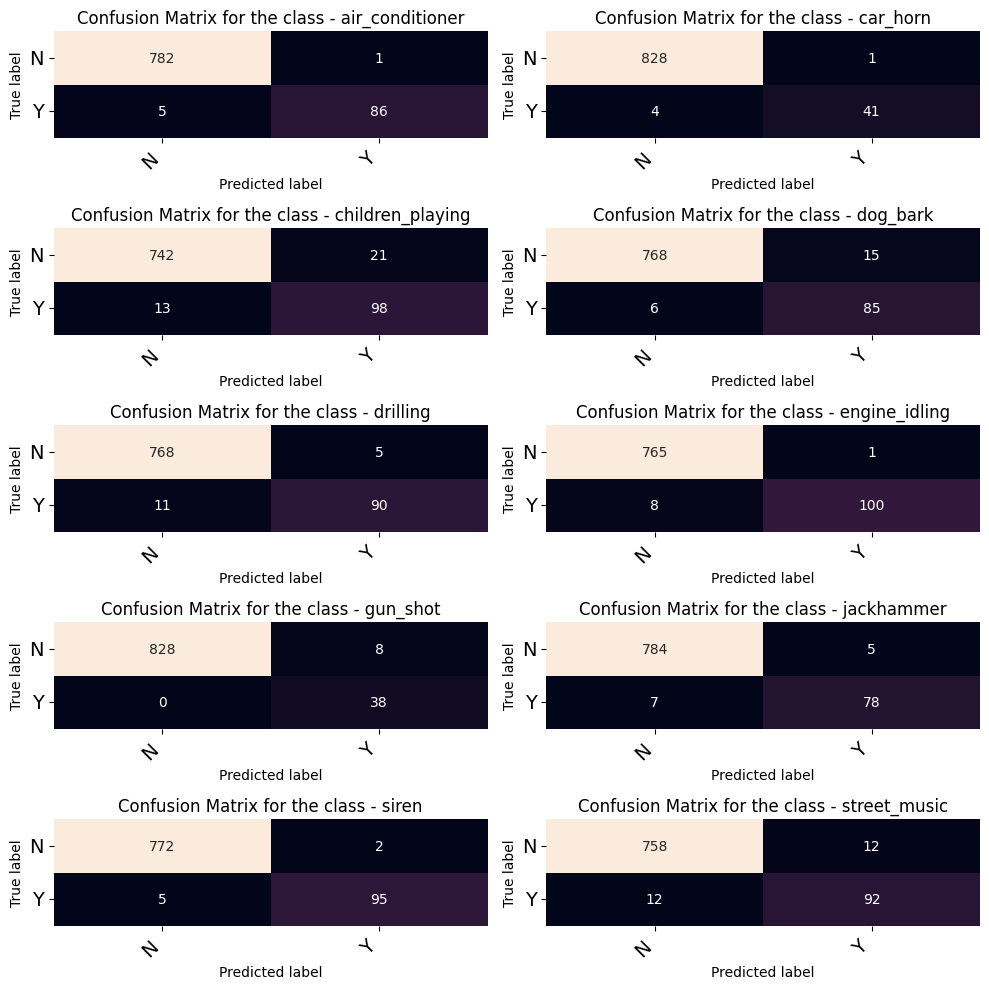

In [ ]:

fig, ax = plt.subplots(5, 2, figsize=(10, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, class_names):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
fig.tight_layout()

plt.show()

## History:

In [ ]:
def plot_model_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
print(history.params)


NameError: name 'history' is not defined

In [ ]:
plot_model_history(history)

# Insights:

In [ ]:
!pip install pydot
!pip install pydot_ng
!pip install graphviz
!pip install plot_model

In [ ]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot


In [ ]:
print(model2.summary())

In [ ]:
plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False , dpi=96)